# Career Trajectories

## 8.1 Introduction

This chapter analyzes career trajectories using batting and fielding data from the Lahman database.

## 8.2 Mickey Mantle's Batting Trajectory

#### Load Lahman data

Using the Lahman database to obtain season-by-season hitting statistics for Mickey Mantle.

In [1]:
import pandas as pd
import numpy as np

people = pd.read_csv('../data/lahman/People.csv')
batting = pd.read_csv('../data/lahman/Batting.csv')

Extract Mickey Mantle's playerID from the People data frame.

In [2]:
mantle_id = people.loc[
    (people['nameFirst'] == 'Mickey') & (people['nameLast'] == 'Mantle'),
    'playerID'
].iloc[0]

print(mantle_id)

mantlmi01


Certain statistics like `SF` (sacrifice flies) and `HBP` (hit by pitch) were not recorded for older seasons and are coded as `NaN`. I have set these values to 0.

In [3]:
batting = batting.fillna({'SF': 0, 'HBP': 0})

### Compute player age and statistics

Major League Baseball defines a player's age as their age on June 30 of that season. The `get_stats()` function computes:
- **Age**: Adjusted for birth month (if born July or later, add 1 to birth year)
- **SLG**: Slugging percentage
- **OBP**: On-base percentage  
- **OPS**: On-base plus slugging

In [4]:
def get_stats(player_id):
    player_batting = batting[batting['playerID'] == player_id].copy()
    
    player_info = people[people['playerID'] == player_id].iloc[0]
    
    # Adjust birth year if born in July or later
    birthyear = player_info['birthYear']
    if player_info['birthMonth'] >= 7:
        birthyear += 1
    
    player_batting['Age'] = player_batting['yearID'] - birthyear
    
    player_batting['SLG'] = (
        (player_batting['H'] - player_batting['2B'] - player_batting['3B'] - player_batting['HR'] + 
         2 * player_batting['2B'] + 
         3 * player_batting['3B'] + 
         4 * player_batting['HR']) / player_batting['AB']
    )
    
    player_batting['OBP'] = (
        (player_batting['H'] + player_batting['BB'] + player_batting['HBP']) / 
        (player_batting['AB'] + player_batting['BB'] + player_batting['HBP'] + player_batting['SF'])
    )
    
    player_batting['OPS'] = player_batting['SLG'] + player_batting['OBP']
    
    return player_batting[['Age', 'SLG', 'OBP', 'OPS']]

In [5]:
mantle_stats = get_stats(mantle_id)
mantle_stats

,Age,SLG,OBP,OPS
70266,19.0,0.442815,0.348958,0.791774
70267,20.0,0.530055,0.394231,0.924285
70268,21.0,0.496746,0.398148,0.894894
70269,22.0,0.524862,0.408320,0.933182
70270,23.0,0.611219,0.430818,1.042036
70271,24.0,0.705441,0.463902,1.169343
70272,25.0,0.664557,0.512039,1.176595
70273,26.0,0.591522,0.443252,1.034774
70274,27.0,0.513863,0.390282,0.904145
70275,28.0,0.557875,0.399068,0.956943


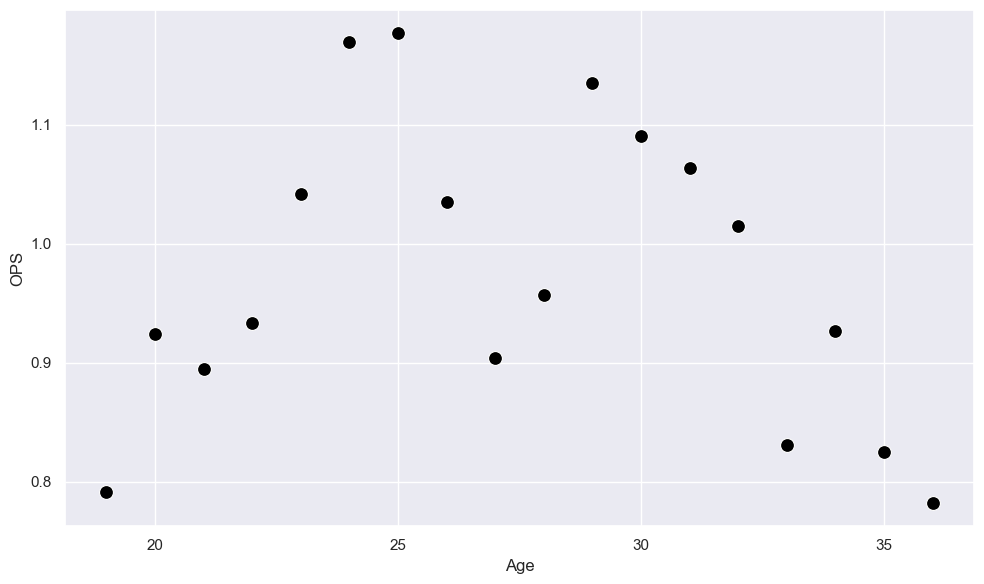

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

ax.set_xlabel('Age')
ax.set_ylabel('OPS')
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()

Mantle’s OPS values tend to increase from age 19 to his late 20s, and then generally decrease until his retirement at age 36.

### Fitting a Quadratic Model

A quadratic curve models the career trajectory, where performance increases to a peak age and then declines. The model is:

$$\text{OPS} \sim (Age - 30) + (Age - 30)^2$$

This centers the age variable at 30, making coefficients easier to interpret.

In [7]:
import statsmodels.api as sm

def fit_model(d):
    d = d.copy()
    d['Age_centered'] = d['Age'] - 30
    d['Age_squared'] = (d['Age'] - 30) ** 2
    
    X = sm.add_constant(d[['Age_centered', 'Age_squared']])
    y = d['OPS']
    
    fit = sm.OLS(y, X).fit()
    
    b0 = fit.params['const']
    b1 = fit.params['Age_centered']
    b2 = fit.params['Age_squared']
    Age_max = 30 - b1 / b2 / 2
    Max = b0 - b1 ** 2 / b2 / 4
    
    return {'fit': fit, 'Age_max': Age_max, 'Max': Max}

#### Fit the quadratic model to Mantle's career data.

In [8]:
mantle_fit = fit_model(mantle_stats)

print(mantle_fit['fit'].params)

const           1.043134
Age_centered   -0.022883
Age_squared    -0.003869
dtype: float64


In [9]:
print(f"Age at peak: {mantle_fit['Age_max']:.2f}")
print(f"Maximum OPS: {mantle_fit['Max']:.2f}")

Age at peak: 27.04
Maximum OPS: 1.08


#### The best fitting curve is given by:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mn>1.04313</mn>
  <mo>&#x2212;</mo>
  <mn>0.02288</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mn>0.00387</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <msup>
    <mo stretchy="false">)</mo>
    <mn>2</mn>
  </msup>
  <mstyle scriptlevel="0">
    <mspace width="0.167em"></mspace>
  </mstyle>
</math>

Mantle's peak: age 27, OPS 1.08. The curvature parameter (-0.00387) shows OPS declined ~0.004 per year after peak performance.

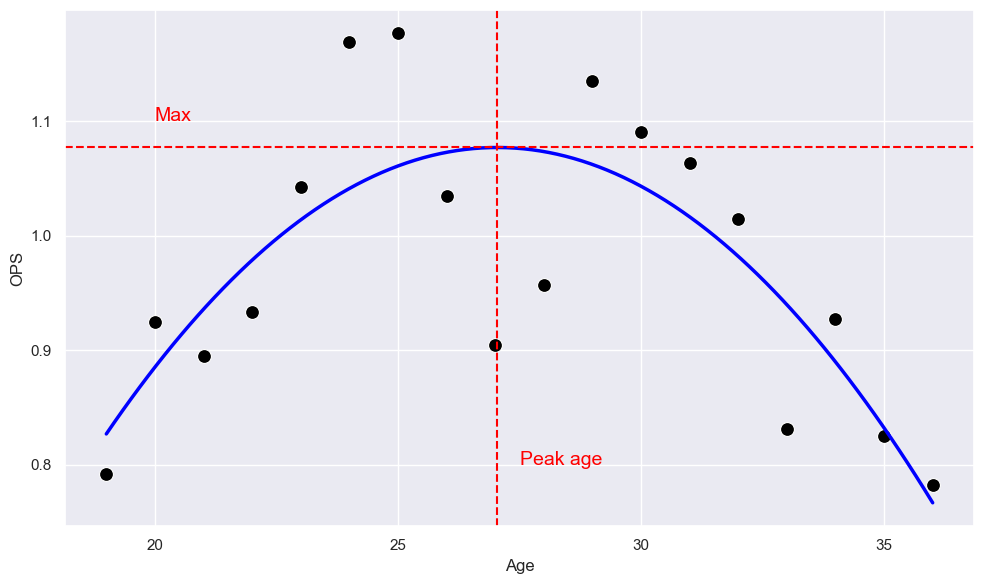

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

age_range = np.linspace(mantle_stats['Age'].min(), mantle_stats['Age'].max(), 100)
age_centered = age_range - 30
age_squared = age_centered ** 2

X_pred = pd.DataFrame({
    'Age_centered': age_centered,
    'Age_squared': age_squared
})
X_pred = sm.add_constant(X_pred)

ops_pred = mantle_fit['fit'].predict(X_pred)

ax.plot(age_range, ops_pred, color='blue', linewidth=2.5)

ax.axvline(x=mantle_fit['Age_max'], color='red', linestyle='--')

ax.axhline(y=mantle_fit['Max'], color='red', linestyle='--')

ax.text(27.5, 0.8, 'Peak age', color='red', fontsize=14)
ax.text(20, 1.1, 'Max', color='red', fontsize=14)

ax.set_xlabel('Age')
ax.set_ylabel('OPS')
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()


In [11]:
import warnings
warnings.filterwarnings('ignore')

mantle_fit['fit'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    OPS   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     11.34
Date:                Sun, 28 Dec 2025   Prob (F-statistic):            0.00100
Time:                        19:14:03   Log-Likelihood:                 20.640
No. Observations:                  18   AIC:                            -35.28
Df Residuals:                      15   BIC:                            -32.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0431      0.028     37.387      0.000       0.984       1.103
Age_centered    -0.0229      0.006     -4.059      0.001      -0.035      -0.011
Age_squared     -0.0039      0.001     -4.671      0.000      -0.006      -0.002
==============================================================================
Omnibus:                        1.098   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.721
Skew:                          -0.472   Prob(JB):                        0.697
Kurtosis:                       2.738   Cond. No.                         68.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
print(f"Residual Standard Error: {np.sqrt(mantle_fit['fit'].mse_resid)}")

Residual Standard Error: 0.08420947610713088


R² = 0.602 the model explains 60% of OPS variability. The residual standard error of 0.084 indicates that approximately 68% of the model's predictions fall within ±0.084 OPS of the actual values.



## 8.3 Comparing Trajectories

### 8.3.1 Some preliminary work

In [13]:
career_ab = batting.groupby('playerID')['AB'].sum().reset_index()
career_ab.columns = ['playerID', 'AB_career']

batting_2000 = career_ab.merge(batting, on='playerID')
batting_2000 = batting_2000[batting_2000['AB_career'] >= 2000]

In [14]:
fielding = pd.read_csv('../data/lahman/Fielding.csv')

positions = (fielding
    .groupby(['playerID', 'POS'])['G']
    .sum()
    .reset_index()
    .rename(columns={'G': 'Games'})
)

positions = positions.sort_values(['playerID', 'Games'], ascending=[True, False])

positions = positions.groupby('playerID').first().reset_index()

In [15]:
batting_2000 = batting_2000.merge(
    positions[['playerID', 'POS', 'Games']], on='playerID')

### 8.3.2 Computing career statistics

In [16]:
my_vars = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB']

c_totals = (batting_2000
    .groupby('playerID')[my_vars]
    .sum()
    .reset_index()
)

c_totals.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,1402,1383.0,240.0
1,abbated01,855,3044,355,772,99,43,11,324.0,289,283.0,142.0
2,abbotku01,702,2044,273,523,109,23,62,242.0,133,571.0,22.0
3,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,1476,1840.0,400.0
4,abreujo02,1446,5607,769,1587,328,17,263,960.0,432,1246.0,11.0


In [17]:
c_totals['AVG'] = c_totals['H'] / c_totals['AB']
c_totals['SLG'] = (
    (c_totals['H'] - c_totals['2B'] - c_totals['3B'] - c_totals['HR'] +
     2 * c_totals['2B'] + 
     3 * c_totals['3B'] + 
     4 * c_totals['HR']) / c_totals['AB']
)

c_totals.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,AVG,SLG
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,1402,1383.0,240.0,0.304998,0.554513
1,abbated01,855,3044,355,772,99,43,11,324.0,289,283.0,142.0,0.253614,0.325230
2,abbotku01,702,2044,273,523,109,23,62,242.0,133,571.0,22.0,0.255871,0.422701
3,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,1476,1840.0,400.0,0.291274,0.474764
4,abreujo02,1446,5607,769,1587,328,17,263,960.0,432,1246.0,11.0,0.283039,0.488318


In [18]:
c_totals = c_totals.merge(positions[['playerID', 'POS']], on='playerID')

position_values = {
    'C': 240,   
    'SS': 168,  
    '2B': 132,  
    '3B': 84,   
    'OF': 48,   
    '1B': 12,   
}

c_totals['Value_POS'] = c_totals['POS'].map(position_values).fillna(0)

### 8.3.3 Computing similarity scores

In [19]:
def similar(p, number=10):
    P = c_totals[c_totals['playerID'] == p].iloc[0]
    
    result = c_totals.copy()
    
    result['sim_score'] = (
        1000 -
        np.floor(np.abs(result['G'] - P['G']) / 20) -
        np.floor(np.abs(result['AB'] - P['AB']) / 75) -
        np.floor(np.abs(result['R'] - P['R']) / 10) -
        np.floor(np.abs(result['H'] - P['H']) / 15) -
        np.floor(np.abs(result['2B'] - P['2B']) / 5) -
        np.floor(np.abs(result['3B'] - P['3B']) / 4) -
        np.floor(np.abs(result['HR'] - P['HR']) / 2) -
        np.floor(np.abs(result['RBI'] - P['RBI']) / 10) -
        np.floor(np.abs(result['BB'] - P['BB']) / 25) -
        np.floor(np.abs(result['SO'] - P['SO']) / 150) -
        np.floor(np.abs(result['SB'] - P['SB']) / 20) -
        np.floor(np.abs(result['AVG'] - P['AVG']) / 0.001) -
        np.floor(np.abs(result['SLG'] - P['SLG']) / 0.002) -
        np.abs(result['Value_POS'] - P['Value_POS'])
    )
    
    return result.sort_values('sim_score', ascending=False).head(number)

In [20]:
similar(mantle_id, 6)

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,AVG,SLG,POS,Value_POS,sim_score
1511,mantlmi01,2401,8102,1677,2415,344,72,536,1509.0,1733,1710.0,153.0,0.298075,0.556776,OF,48.0,1000.0
2388,thomafr04,2322,8199,1494,2468,495,12,521,1704.0,1667,1397.0,32.0,0.301012,0.554946,1B,12.0,856.0
1544,matheed01,2391,8537,1509,2315,354,72,512,1453.0,1444,1487.0,68.0,0.271173,0.509430,3B,84.0,853.0
2139,schmimi01,2404,8352,1506,2234,408,59,548,1595.0,1507,1883.0,174.0,0.267481,0.527299,3B,84.0,848.0
2185,sheffga01,2576,9217,1636,2689,467,27,509,1676.0,1475,1171.0,253.0,0.291744,0.513942,OF,48.0,847.0
2254,sosasa01,2354,8813,1475,2408,379,45,609,1667.0,929,2306.0,234.0,0.273233,0.533757,OF,48.0,831.0


Five players most similar to Mantle: Frank Thomas, Eddie Mathews, Mike Schmidt, Gary Sheffield, and Sammy Sosa.

### 8.3.4 Defining age, OBP, SLG, and OPS variables

In [21]:
batting_2000 = (batting_2000
    .groupby(['playerID', 'yearID'], as_index=False)
    .agg({
        'G': 'sum',
        'AB': 'sum',
        'R': 'sum',
        'H': 'sum',
        '2B': 'sum',
        '3B': 'sum',
        'HR': 'sum',
        'RBI': 'sum',
        'SB': 'sum',
        'CS': 'sum',
        'BB': 'sum',
        'SH': 'sum',
        'SF': 'sum',
        'HBP': 'sum',
        'AB_career': 'first',
        'POS': 'first'
    })
)

batting_2000['SLG'] = (
    (batting_2000['H'] - batting_2000['2B'] - batting_2000['3B'] - batting_2000['HR'] +
     2 * batting_2000['2B'] + 
     3 * batting_2000['3B'] + 
     4 * batting_2000['HR']) / batting_2000['AB']
)

batting_2000['OBP'] = (
    (batting_2000['H'] + batting_2000['BB'] + batting_2000['HBP']) / 
    (batting_2000['AB'] + batting_2000['BB'] + batting_2000['HBP'] + batting_2000['SF'])
)

batting_2000['OPS'] = batting_2000['SLG'] + batting_2000['OBP']

In [22]:
batting_2000 = batting_2000.merge(
    people[['playerID', 'birthYear', 'birthMonth']], 
    on='playerID', 
    how='inner'
)

batting_2000['Birthyear'] = batting_2000.apply(
    lambda row: row['birthYear'] + 1 if row['birthMonth'] >= 7 else row['birthYear'],
    axis=1
)

batting_2000['Age'] = batting_2000['yearID'] - batting_2000['Birthyear']

In [23]:
batting_2000 = batting_2000.dropna(subset=['Age'])

### 8.3.5 Fitting and plotting trajectories

In [24]:
def plot_trajectories(player, n_similar=5, ncol=2):
    first_name, last_name = player.split(' ', 1)
    
    player_id = people.loc[
        (people['nameFirst'] == first_name) & (people['nameLast'] == last_name),
        'playerID'
    ].iloc[0]
    
    player_list = similar(player_id, n_similar)['playerID'].tolist()
    
    batting_new = (batting_2000[batting_2000['playerID'].isin(player_list)]
        .merge(people[['playerID', 'nameFirst', 'nameLast']], on='playerID')
        .assign(Name=lambda x: x['nameFirst'] + ' ' + x['nameLast'])
    )
    
    grid = sns.FacetGrid(batting_new, col='Name', col_wrap=ncol, 
                      height=4, aspect=1.0, sharey=True)
    grid.map_dataframe(sns.regplot, x='Age', y='OPS', order=2,
                    scatter=False, line_kws={'linewidth': 2})
    grid.set_titles("{col_name}")
    grid.set_axis_labels('Age', 'OPS')
    
    for ax in grid.axes.flat:
        ax.set_facecolor('#EBEBEB')
        ax.grid(True, color='white', linewidth=1)
    
    plt.tight_layout()
    return grid

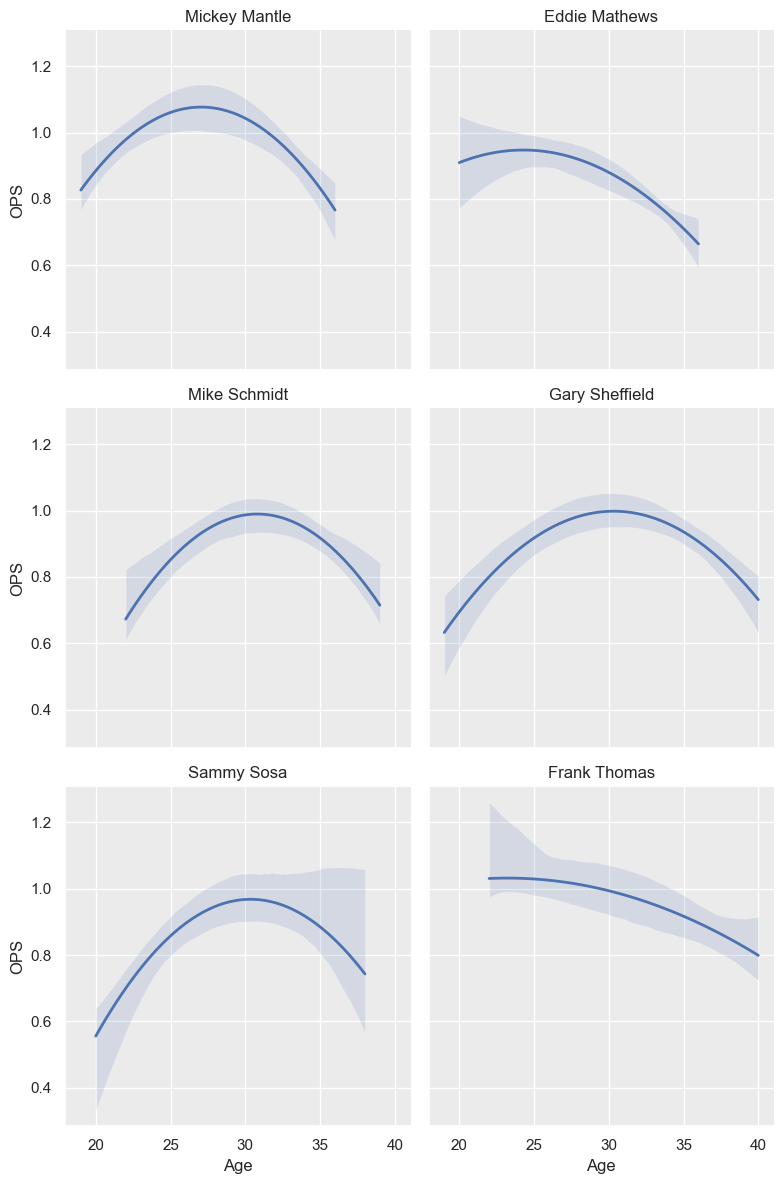

In [25]:
plot_trajectories("Mickey Mantle", 6, 2)
plt.show()

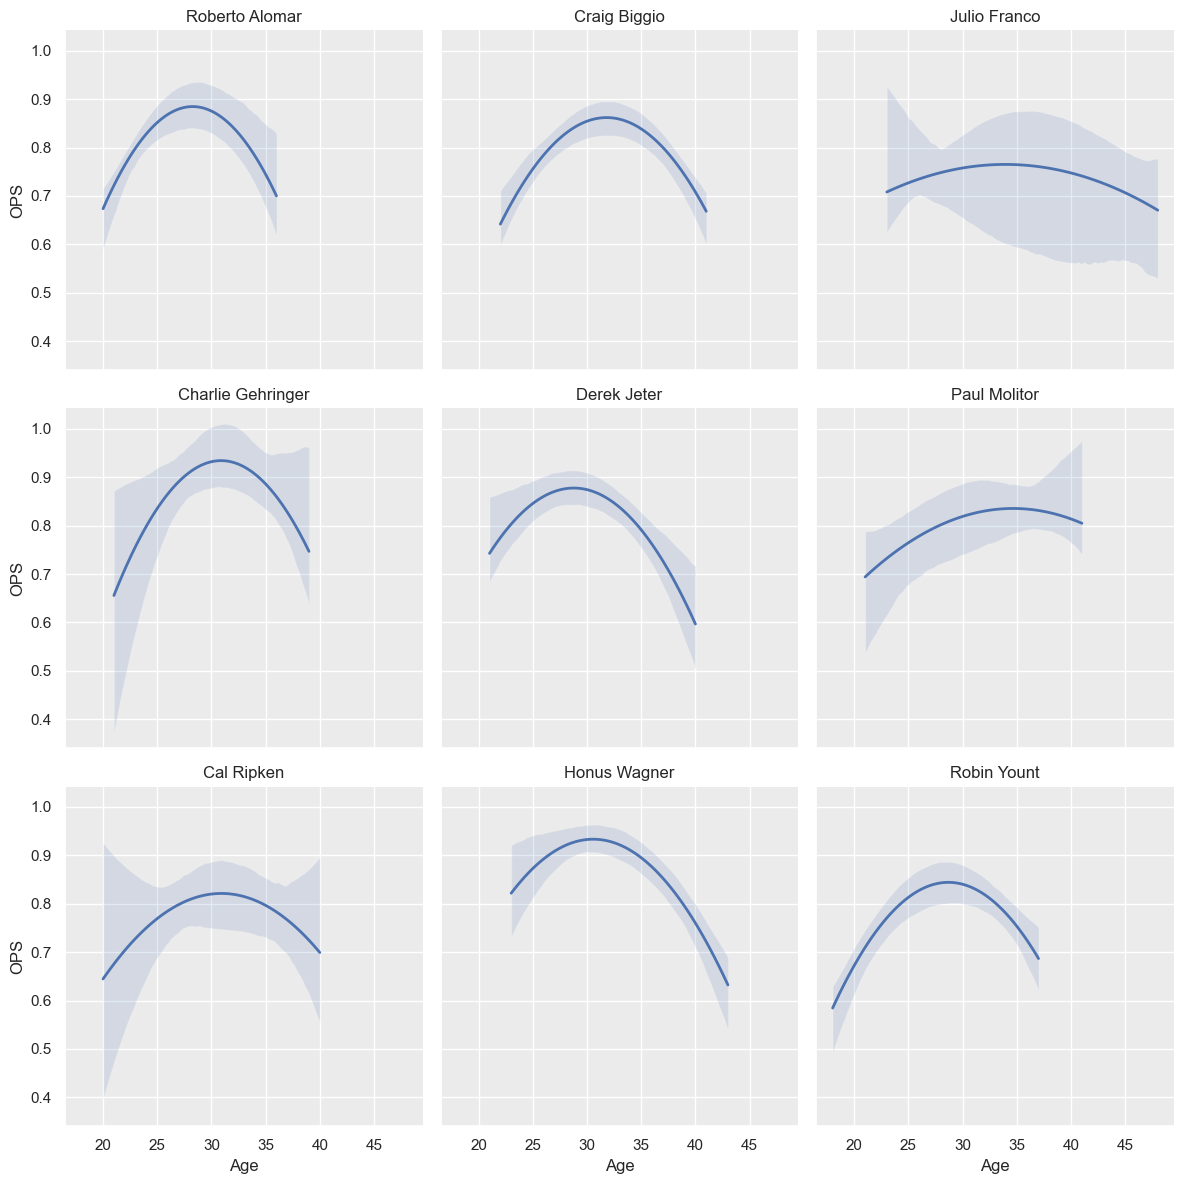

In [26]:
dj_plot = plot_trajectories("Derek Jeter", 9, 3)

In [27]:
regressions = (dj_plot.data
    .groupby('Name')
    .apply(lambda d: pd.DataFrame({
        'term': ['(Intercept)', 'I(Age - 30)', 'I((Age - 30)^2)'],
        'estimate': (fit := sm.OLS(
            d['OPS'],
            sm.add_constant(d.assign(
                **{'I(Age - 30)': d['Age'] - 30,
                   'I((Age - 30)^2)': (d['Age'] - 30) ** 2}
            )[['I(Age - 30)', 'I((Age - 30)^2)']]
        )).fit()).params.values,
        'std.error': fit.bse.values,
        'statistic': fit.tvalues.values,
        'p.value': fit.pvalues.values
    }), include_groups=False)
    .reset_index(level=1, drop=True)
    .reset_index()
)

regressions.head(6)

,Name,term,estimate,std.error,statistic,p.value
0,Cal Ripken,(Intercept),0.819892,0.043557,18.823238,2.736553e-13
1,Cal Ripken,I(Age - 30),0.002729,0.004786,0.570225,5.755743e-01
2,Cal Ripken,I((Age - 30)^2),-0.001481,0.000887,-1.669551,1.123069e-01
3,Charlie Gehringer,(Intercept),0.931977,0.041517,22.447981,1.601936e-13
4,Charlie Gehringer,I(Age - 30),0.005066,0.005042,1.004935,3.298851e-01
5,Charlie Gehringer,I((Age - 30)^2),-0.002850,0.001033,-2.757409,1.401886e-02


In [28]:
S = (regressions
    .groupby('Name')
    .apply(lambda g: pd.Series({
        'b1': g['estimate'].iloc[0],
        'b2': g['estimate'].iloc[1],
        'Curvature': g['estimate'].iloc[2],
        'Age_max': round(30 - g['estimate'].iloc[1] / g['estimate'].iloc[2] / 2, 1),
        'Max': round(g['estimate'].iloc[0] - g['estimate'].iloc[1] ** 2 / g['estimate'].iloc[2] / 4, 3)
    }), include_groups=False)
    .reset_index()
)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


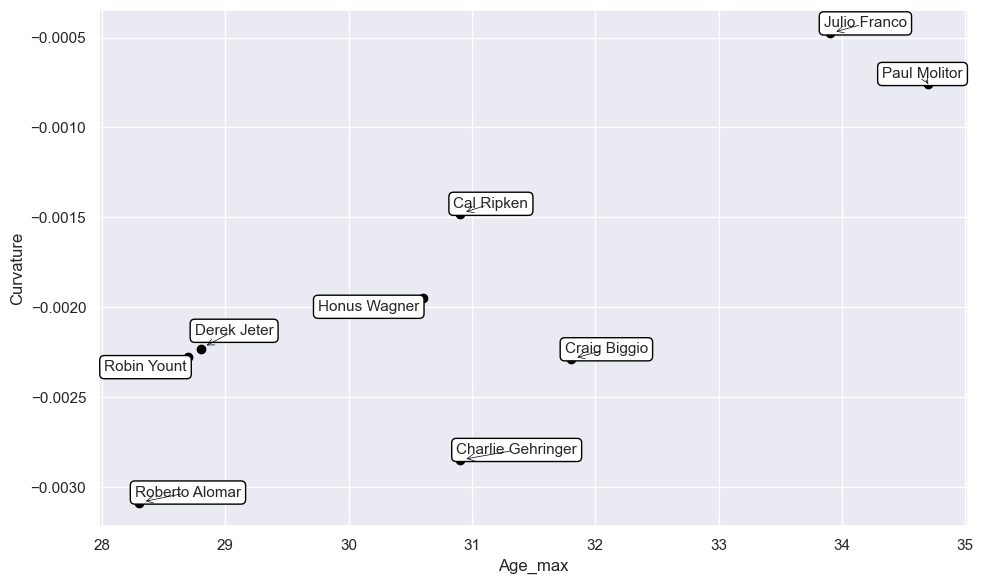

In [29]:
from adjustText import adjust_text
import warnings
warnings.filterwarnings('ignore', module='adjustText')

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(S['Age_max'], S['Curvature'], color='black')

texts = []
for idx, row in S.iterrows():
    texts.append(ax.text(row['Age_max'], row['Curvature'], row['Name'], 
                         fontsize=11, ha='center',
                         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black')))

adjust_text(texts,
            x=S['Age_max'].values,
            y=S['Curvature'].values,
            force_points=(2, 2),
            expand_points=(2, 2),
            arrowprops=dict(arrowstyle='->', color='black', lw=0.5, shrinkA=5, shrinkB=5),
            ax=ax)

ax.set_xlabel('Age_max')
ax.set_ylabel('Curvature')
ax.grid(True)
plt.tight_layout()
plt.show()

Alomar peaked early while Franco and Molitor peaked late in their careers. Alomar and Gehringer showed the most rapid post-peak decline.

## 8.4 General Patterns of Peak Ages

### 8.4.1 Computing all fitted trajectories

In [30]:
not_current_playerID = people[
    people['finalGame'] < '2021-11-01'
]['playerID']

batting_2000 = batting_2000[
    batting_2000['playerID'].isin(not_current_playerID)
]

In [31]:
midcareers = (batting_2000
    .groupby('playerID')
    .agg(
        Midyear=('yearID', lambda x: (x.min() + x.max()) / 2),
        AB_total=('AB_career', 'first')
    )
    .reset_index()
)

batting_2000 = batting_2000.merge(midcareers, on='playerID')

In [32]:
models = (batting_2000
    .groupby('playerID')
    .apply(lambda d: pd.DataFrame({
        'term': ['(Intercept)', 'I(Age - 30)', 'I((Age - 30)^2)'],
        'estimate': (fit := sm.OLS(
            d['OPS'],
            sm.add_constant(d.assign(
                **{'I(Age - 30)': d['Age'] - 30,
                   'I((Age - 30)^2)': (d['Age'] - 30) ** 2}
            )[['I(Age - 30)', 'I((Age - 30)^2)']]
        )).fit()).params.values,
        'std.error': fit.bse.values,
        'statistic': fit.tvalues.values,
        'p.value': fit.pvalues.values
    }), include_groups=False)
    .reset_index(level=1, drop=True)
    .reset_index()
)

In [33]:
beta_coefs = (models
    .groupby('playerID')
    .apply(lambda g: pd.Series({
        'A': g['estimate'].iloc[0],
        'B': g['estimate'].iloc[1],
        'C': g['estimate'].iloc[2]
    }), include_groups=False)
    .reset_index()
    .assign(Peak_age=lambda x: 30 - x['B'] / 2 / x['C'])
    .merge(midcareers, on='playerID')
)

### 8.4.2 Patterns of peak age over time

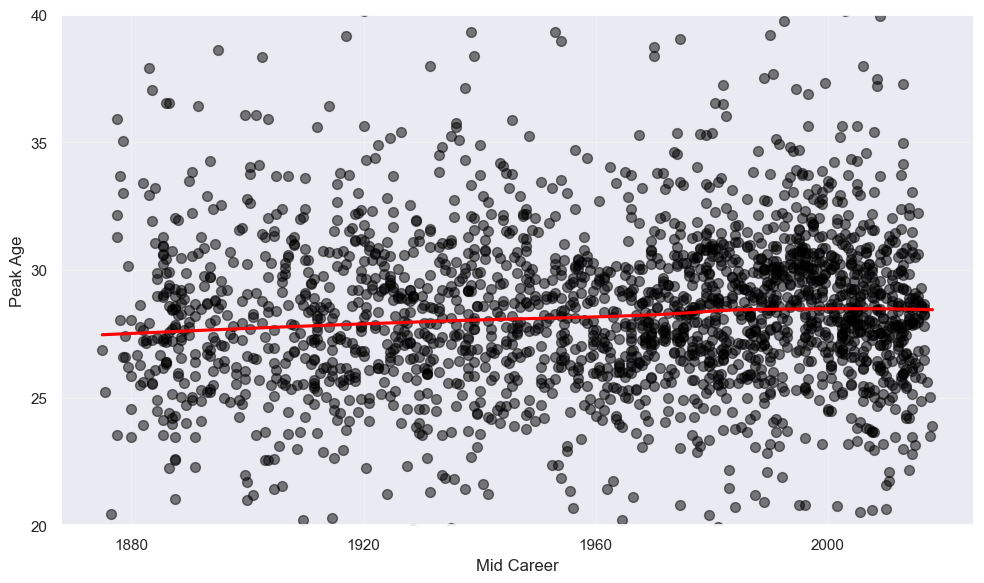

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(data=beta_coefs, x='Midyear', y='Peak_age',
            scatter_kws={'alpha': 0.5, 'color': 'black', 's': 50},
            line_kws={'color': 'red'},
            lowess=True, ax=ax)

ax.set_ylim(20, 40)
ax.set_xlabel('Mid Career')
ax.set_ylabel('Peak Age')
ax.set_xticks([1880, 1920, 1960, 2000])
ax.set_yticks([20, 25, 30, 35, 40])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

There has been a gradual increase in peak age over time. The peak age for an average player was approximately 27 in 1880 and this average has gradually increased to 28 from 1880 to 2016.

### 8.4.3 Peak age and career at-bats

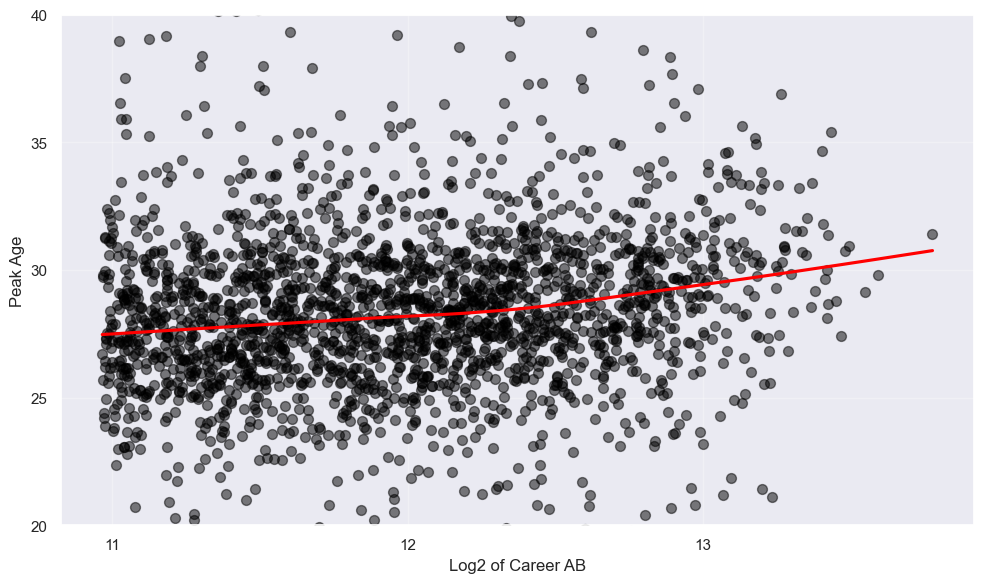

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(data=beta_coefs, x=np.log2(beta_coefs['AB_total']), y='Peak_age',
            scatter_kws={'alpha': 0.5, 'color': 'black', 's': 50},
            line_kws={'color': 'red'},
            lowess=True, ax=ax)

ax.set_ylim(20, 40)
ax.set_xlabel('Log2 of Career AB')
ax.set_ylabel('Peak Age')
ax.set_xticks([11, 12, 13])
ax.set_yticks([20, 25, 30, 35, 40])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Players with short careers (~2000 at-bats) tend to peak around age 27, while those with long careers (9000+ at-bats) peak closer to age 30. This shows a clear positive relationship between career length and peak age.

## 8.5 Trajectories and Fielding Position

In [36]:
batting_2000a = batting_2000[
    (batting_2000['Midyear'] >= 1985) & (batting_2000['Midyear'] <= 1995)
]
batting_2000a = batting_2000a.dropna(subset=['OPS'])

In [37]:
models = (batting_2000a
    .groupby('playerID')
    .apply(lambda d: pd.DataFrame({
        'term': ['(Intercept)', 'I(Age - 30)', 'I((Age - 30)^2)'],
        'estimate': (fit := sm.OLS(
            d['OPS'],
            sm.add_constant(d.assign(
                **{'I(Age - 30)': d['Age'] - 30,
                   'I((Age - 30)^2)': (d['Age'] - 30) ** 2}
            )[['I(Age - 30)', 'I((Age - 30)^2)']]
        )).fit()).params.values,
        'std.error': fit.bse.values,
        'statistic': fit.tvalues.values,
        'p.value': fit.pvalues.values
    }), include_groups=False)
    .reset_index(level=1, drop=True)
    .reset_index()
)

beta_estimates = (models
    .groupby('playerID')
    .apply(lambda g: pd.Series({
        'A': g['estimate'].iloc[0],
        'B': g['estimate'].iloc[1],
        'C': g['estimate'].iloc[2]
    }), include_groups=False)
    .reset_index()
    .assign(Peak_age=lambda x: 30 - x['B'] / 2 / x['C'])
    .merge(midcareers, on='playerID')
    .merge(positions, on='playerID')
    .rename(columns={'POS': 'Position'})
)

In [38]:
beta_fielders = (beta_estimates[
    beta_estimates['Position'].isin(['1B', '2B', '3B', 'SS', 'C', 'OF'])
]
    .merge(people, on='playerID')
)

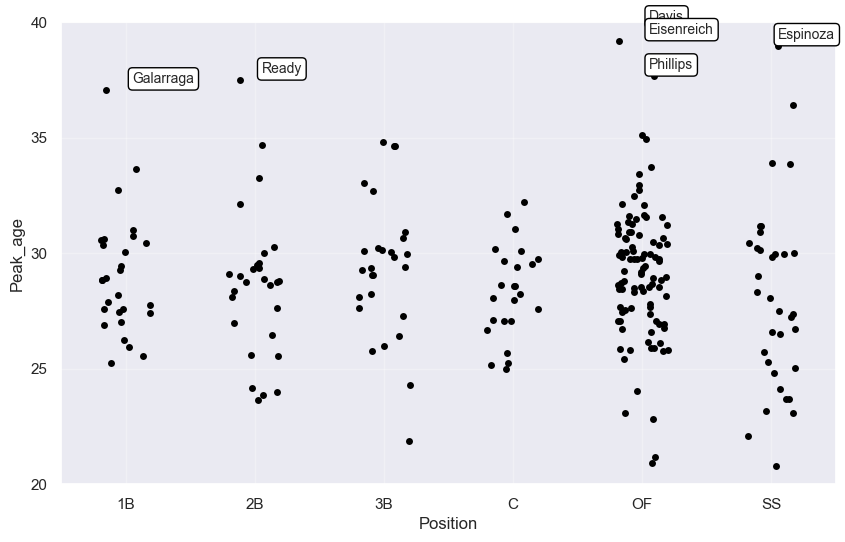

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.stripplot(data=beta_fielders, x='Position', y='Peak_age', 
              color='black', jitter=0.2, ax=ax, 
              order=['1B', '2B', '3B', 'C', 'OF', 'SS'])

ax.set_ylim(20, 40)


outliers = beta_fielders[(beta_fielders['Peak_age'] > 37) & 
                          (beta_fielders['Peak_age'] <= 40)].copy()

positions = ['1B', '2B', '3B', 'C', 'OF', 'SS']

for _, row in outliers.iterrows():
    x_pos = positions.index(row['Position'])
    ax.annotate(row['nameLast'], 
                xy=(x_pos, row['Peak_age']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
ax.set_yticks([20, 25, 30, 35, 40])
ax.set_xlabel('Position')
ax.set_ylabel('Peak_age')
ax.grid(True, alpha=0.3)
plt.show()

For all fielding positions, the peak ages for these 1990 players tend to fall between 27 and 32.